# 1. DATA EXTRACTION & LOADING

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [14]:
# World Bank API endpoints for education data
base_url = "https://api.worldbank.org/v2/country/all/indicator/"

# Key education indicators
indicators = {
    "SE.PRM.NENR": "Primary School Net Enrollment Rate (%)",
    "SE.PRM.CMPT.ZS": "Primary Completion Rate (%)", 
    "SE.PRM.ENRR.FE": "Primary School Enrollment Female (%)",
    "SE.PRM.ENRR.MA": "Primary School Enrollment Male (%)",
    "SP.POP.TOTL": "Population Total",
    "NY.GDP.PCAP.CD": "GDP per capita (USD)",
    "SP.RUR.TOTL.ZS": "Rural Population (%)",
    "SP.URB.TOTL.IN.ZS": "Urban Population (%)"
}

In [17]:
# Extract country name from nested 'country' column
if 'country' in df.columns and isinstance(df['country'].iloc[0], dict):
    df['country_name'] = df['country'].apply(lambda x: x.get('value') if isinstance(x, dict) else x)
else:
    df['country_name'] = df['country']

# Rename columns
df = df.rename(columns={
    'date': 'year',
    'value': 'indicator_value',
    'indicator_name': 'indicator_name'
})

# Convert year to numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Drop rows with missing critical values
df = df.dropna(subset=['country_name', 'year', 'indicator_value', 'indicator_name'])

# Pivot
df_pivot = df.pivot_table(
    index=['country_name', 'year'],
    columns='indicator_name',
    values='indicator_value',
    aggfunc='first'
).reset_index()

# Flatten columns
df_pivot.columns.name = None

# Rename to short names
df_pivot = df_pivot.rename(columns={
    'Primary School Net Enrollment Rate (%)': 'primary_enrollment_rate',
    'Primary Completion Rate (%)': 'primary_completion_rate',
    'Primary School Enrollment Female (%)': 'female_enrollment_rate',
    'Primary School Enrollment Male (%)': 'male_enrollment_rate',
    'Population Total': 'population_total',
    'GDP per capita (USD)': 'gdp_per_capita',
    'Rural Population (%)': 'rural_population_pct',
    'Urban Population (%)': 'urban_population_pct'
})

print(f"✓ Pivoted dataset shape: {df_pivot.shape}")
print(df_pivot.head())


✓ Pivoted dataset shape: (1992, 10)
  country_name  year  gdp_per_capita  population_total  \
0  Afghanistan  2015      565.569730        33831764.0   
1  Afghanistan  2016      522.082216        34700612.0   
2  Afghanistan  2017      525.469771        35688935.0   
3  Afghanistan  2018      491.337221        36743039.0   
4  Afghanistan  2019      496.602504        37856121.0   

   primary_completion_rate  female_enrollment_rate  male_enrollment_rate  \
0                      NaN               85.902367            125.426270   
1                82.910461               85.787956            125.476883   
2                87.253326               85.563492            125.657188   
3                88.735519               86.190132            128.287537   
4                86.175522               88.333580            130.606277   

   primary_enrollment_rate  rural_population_pct  urban_population_pct  
0                      NaN                75.197                24.803  
1           

In [18]:
# Function to fetch data from World Bank API
def fetch_world_bank_data(indicator_code, start_year=2015, end_year=2022):
    url = f"{base_url}{indicator_code}?date={start_year}:{end_year}&format=json&per_page=2000"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if len(data) > 1 and data[1]:
            return pd.DataFrame(data[1])
        else:
            return pd.DataFrame()
    except Exception as e:
        print(f"Failed to fetch data for {indicator_code}: {e}")
        return pd.DataFrame()

# Fetch all indicators
all_data = []
for code, description in indicators.items():
    print(f"• Fetching: {description}")
    df_api = fetch_world_bank_data(code)
    
    if not df_api.empty:
        df_api['indicator_code'] = code
        df_api['indicator_name'] = description
        all_data.append(df_api)
    else:
        print(f"  ⚠ No data available for {code}")

# Combine all fetched data into a single DataFrame
if all_data:
    df = pd.concat(all_data, ignore_index=True)
    print(f"✓ Successfully fetched data from World Bank API")
    print(f"✓ Dataset shape: {df.shape}")
    print(f"✓ Countries covered: {df['countryiso3code'].nunique()}")
else:
    print("❌ No data fetched from the API.")


• Fetching: Primary School Net Enrollment Rate (%)
• Fetching: Primary Completion Rate (%)
• Fetching: Primary School Enrollment Female (%)
• Fetching: Primary School Enrollment Male (%)
• Fetching: Population Total
• Fetching: GDP per capita (USD)
• Fetching: Rural Population (%)
• Fetching: Urban Population (%)
✓ Successfully fetched data from World Bank API
✓ Dataset shape: (16000, 10)
✓ Countries covered: 246


# 2. DATA EXPLORATION & INITIAL ANALYSIS

In [19]:
print("\nDataset Overview:")
print(df.head())

print(f"\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\nBasic Statistics:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe().round(2))


Dataset Overview:
                                           indicator  \
0  {'id': 'SE.PRM.NENR', 'value': 'School enrollm...   
1  {'id': 'SE.PRM.NENR', 'value': 'School enrollm...   
2  {'id': 'SE.PRM.NENR', 'value': 'School enrollm...   
3  {'id': 'SE.PRM.NENR', 'value': 'School enrollm...   
4  {'id': 'SE.PRM.NENR', 'value': 'School enrollm...   

                                             country countryiso3code  date  \
0  {'id': 'ZH', 'value': 'Africa Eastern and Sout...             AFE  2022   
1  {'id': 'ZH', 'value': 'Africa Eastern and Sout...             AFE  2021   
2  {'id': 'ZH', 'value': 'Africa Eastern and Sout...             AFE  2020   
3  {'id': 'ZH', 'value': 'Africa Eastern and Sout...             AFE  2019   
4  {'id': 'ZH', 'value': 'Africa Eastern and Sout...             AFE  2018   

   value unit obs_status  decimal indicator_code  \
0    NaN                        0    SE.PRM.NENR   
1    NaN                        0    SE.PRM.NENR   
2    NaN           

# 3. DATA CLEANING & PREPROCESSING  

In [21]:
# Use df_pivot after pivoting
df = df_pivot.copy()

print("Data Quality Check:")
print(f"Missing values:\n{df.isnull().sum()}")

# Remove rows with missing critical data
critical_columns = ['primary_enrollment_rate', 'country_name', 'year']
original_length = len(df)
df = df.dropna(subset=critical_columns).copy()
print(f"✓ Removed {original_length - len(df)} rows with missing critical data")

# Handle remaining missing numeric values
numeric_columns = ['primary_completion_rate', 'female_enrollment_rate', 'male_enrollment_rate', 'gdp_per_capita']

for col in numeric_columns:
    if col in df.columns:
        # Fill missing values with median
        df[col] = df[col].fillna(df[col].median())

# Ensure rates are within 0-100%
rate_columns = ['primary_enrollment_rate', 'primary_completion_rate', 'female_enrollment_rate', 'male_enrollment_rate']
for col in rate_columns:
    if col in df.columns:
        df[col] = df[col].clip(0, 100)

# Remove outliers for GDP
if 'gdp_per_capita' in df.columns:
    Q1 = df['gdp_per_capita'].quantile(0.25)
    Q3 = df['gdp_per_capita'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['gdp_per_capita'] >= Q1 - 1.5*IQR) & (df['gdp_per_capita'] <= Q3 + 1.5*IQR)].copy()

# Create derived features
print("✓ Creating derived features...")

# Gender parity index
if 'female_enrollment_rate' in df.columns and 'male_enrollment_rate' in df.columns:
    df['gender_parity_index'] = (df['female_enrollment_rate'] / df['male_enrollment_rate']).fillna(1.0)

# Education access level
if 'primary_enrollment_rate' in df.columns:
    df['education_access_level'] = pd.cut(df['primary_enrollment_rate'],
                                          bins=[0, 70, 85, 95, 100],
                                          labels=['Critical', 'Low', 'Moderate', 'High'])

# Development level based on GDP
if 'gdp_per_capita' in df.columns:
    df['development_level'] = pd.cut(df['gdp_per_capita'],
                                     bins=[0, 1000, 4000, 12000, float('inf')],
                                     labels=['Low Income', 'Lower Middle', 'Upper Middle', 'High Income'])

print(f"✓ Final dataset shape: {df.shape}")
print("✓ Data cleaning completed!")


Data Quality Check:
Missing values:
country_name                  0
year                          0
gdp_per_capita               47
population_total              0
primary_completion_rate     609
female_enrollment_rate      359
male_enrollment_rate        359
primary_enrollment_rate    1392
rural_population_pct         16
urban_population_pct         16
dtype: int64
✓ Removed 1392 rows with missing critical data
✓ Creating derived features...
✓ Final dataset shape: (531, 13)
✓ Data cleaning completed!


# 4. EXPLORATORY DATA ANALYSIS (EDA)


4. EXPLORATORY DATA ANALYSIS...


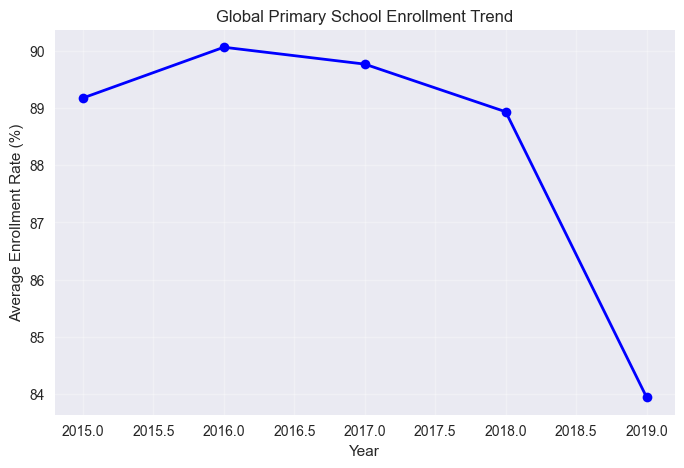

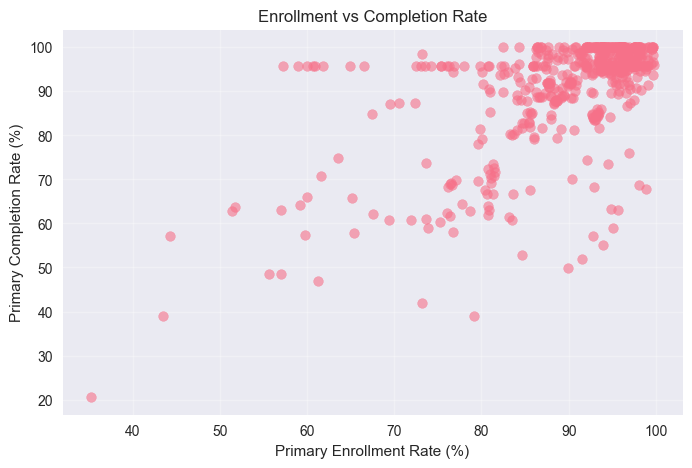

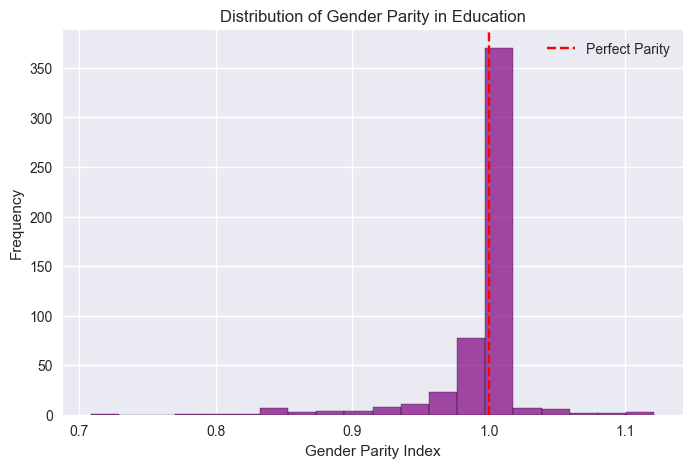

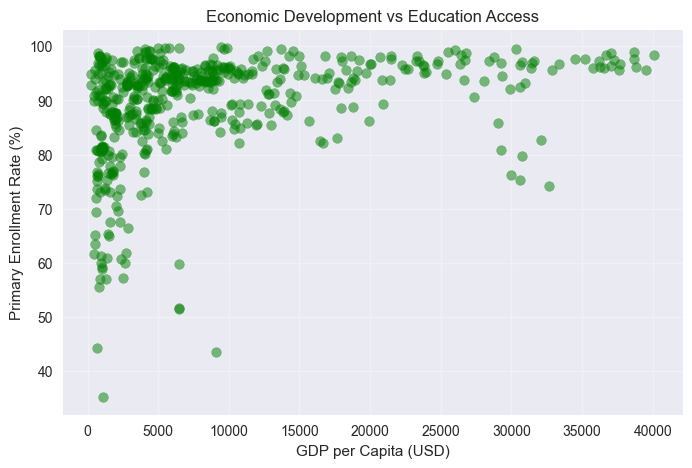

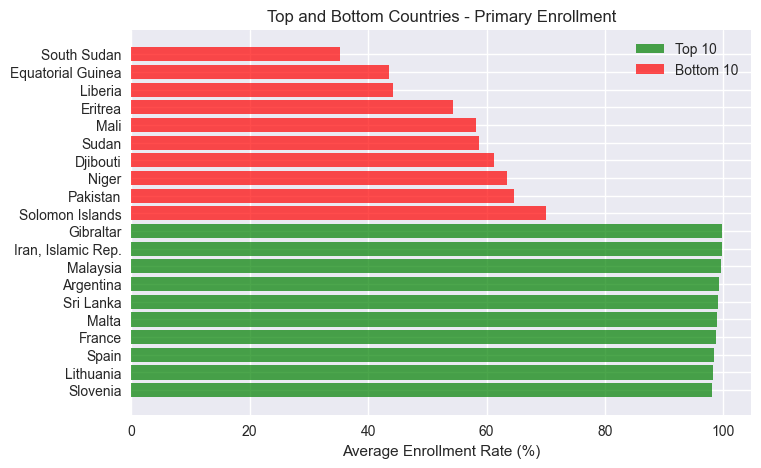

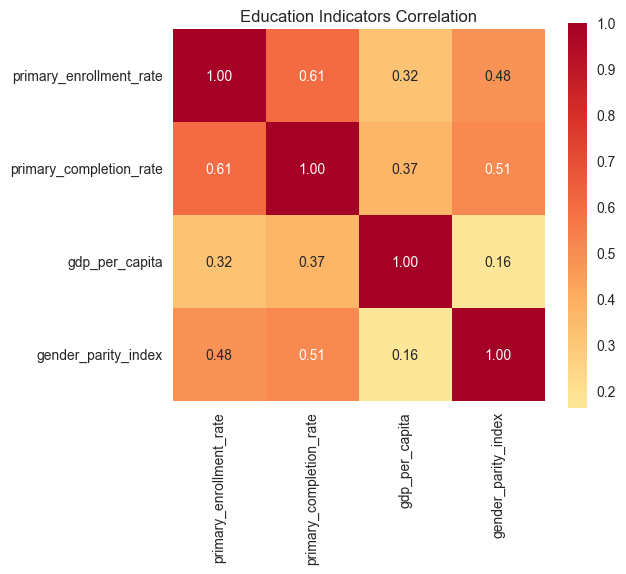

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n4. EXPLORATORY DATA ANALYSIS...")

# 1. Global enrollment trend over time
if 'year' in df.columns:
    yearly_enrollment = df.groupby('year')['primary_enrollment_rate'].mean()
    plt.figure(figsize=(8, 5))
    plt.plot(yearly_enrollment.index, yearly_enrollment.values, marker='o', linewidth=2, color='blue')
    plt.title('Global Primary School Enrollment Trend')
    plt.xlabel('Year')
    plt.ylabel('Average Enrollment Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.show()

# 2. Enrollment vs Completion Rate scatter
if 'primary_completion_rate' in df.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(df['primary_enrollment_rate'], df['primary_completion_rate'], alpha=0.6)
    plt.xlabel('Primary Enrollment Rate (%)')
    plt.ylabel('Primary Completion Rate (%)')
    plt.title('Enrollment vs Completion Rate')
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Gender parity distribution
if 'gender_parity_index' in df.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df['gender_parity_index'], bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(x=1.0, color='red', linestyle='--', label='Perfect Parity')
    plt.xlabel('Gender Parity Index')
    plt.ylabel('Frequency')
    plt.title('Distribution of Gender Parity in Education')
    plt.legend()
    plt.show()

# 4. GDP vs Education access
if 'gdp_per_capita' in df.columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(df['gdp_per_capita'], df['primary_enrollment_rate'], alpha=0.5, color='green')
    plt.xlabel('GDP per Capita (USD)')
    plt.ylabel('Primary Enrollment Rate (%)')
    plt.title('Economic Development vs Education Access')
    plt.grid(True, alpha=0.3)
    plt.show()

# 5. Top 10 and Bottom 10 Countries by Enrollment
plt.figure(figsize=(8, 5))
top_countries = df.groupby('country_name')['primary_enrollment_rate'].mean().nlargest(10)
bottom_countries = df.groupby('country_name')['primary_enrollment_rate'].mean().nsmallest(10)

plt.barh(top_countries.index[::-1], top_countries.values[::-1], color='green', alpha=0.7, label='Top 10')
plt.barh(bottom_countries.index[::-1], bottom_countries.values[::-1], color='red', alpha=0.7, label='Bottom 10')
plt.xlabel('Average Enrollment Rate (%)')
plt.title('Top and Bottom Countries - Primary Enrollment')
plt.legend()
plt.show()

# 6. Correlation heatmap for key indicators
correlation_cols = ['primary_enrollment_rate', 'primary_completion_rate', 'gdp_per_capita', 'gender_parity_index']
correlation_cols = [col for col in correlation_cols if col in df.columns]
if len(correlation_cols) > 1:
    plt.figure(figsize=(6, 5))
    corr_matrix = df[correlation_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, square=True, fmt='.2f')
    plt.title('Education Indicators Correlation')
    plt.show()


# 5. STATISTICAL ANALYSIS & KEY INSIGHTS

In [28]:
print("\n5. STATISTICAL ANALYSIS & KEY INSIGHTS...")

print("\n=== GLOBAL EDUCATION STATISTICS ===")

# Overall statistics
global_enrollment = df['primary_enrollment_rate'].mean()
global_completion = df['primary_completion_rate'].mean() if 'primary_completion_rate' in df.columns else None
countries_analyzed = df['country_name'].nunique()

print(f"Countries Analyzed: {countries_analyzed}")
print(f"Global Average Primary Enrollment: {global_enrollment:.2f}%")
if global_completion is not None:
    print(f"Global Average Primary Completion: {global_completion:.2f}%")

# Regional analysis
if 'region' in df.columns:
    print(f"\n=== REGIONAL ANALYSIS ===")
    regional_stats = df.groupby('region').agg({
        'primary_enrollment_rate': ['mean', 'min', 'max'],
        'country_name': 'nunique'
    }).round(2)
    regional_stats.columns = ['Avg_Enrollment', 'Min_Enrollment', 'Max_Enrollment', 'Countries']
    print(regional_stats.sort_values('Avg_Enrollment'))

# Income level analysis
if 'income_group' in df.columns:
    print(f"\n=== INCOME LEVEL ANALYSIS ===")
    income_stats = df.groupby('income_group').agg({
        'primary_enrollment_rate': 'mean',
        'primary_completion_rate': 'mean' if 'primary_completion_rate' in df.columns else 'first',
        'gender_parity_index': 'mean'
    }).round(2)
    print(income_stats)

# Gender parity insights
if 'gender_parity_index' in df.columns:
    print(f"\n=== GENDER PARITY ANALYSIS ===")
    avg_parity = df['gender_parity_index'].mean()
    countries_below_parity = (df['gender_parity_index'] < 0.95).sum()
    countries_good_parity = (df['gender_parity_index'] >= 0.95).sum()

    print(f"Global Gender Parity Index: {avg_parity:.3f}")
    print(f"Countries with gender gaps (GPI < 0.95): {countries_below_parity}")
    print(f"Countries with good gender parity (GPI ≥ 0.95): {countries_good_parity}")

# COVID-19 impact analysis
if 'year' in df.columns:
    print(f"\n=== COVID-19 IMPACT ANALYSIS ===")
    pre_covid = df[df['year'] <= 2019]['primary_enrollment_rate'].mean()
    covid_period = df[df['year'].isin([2020, 2021])]['primary_enrollment_rate'].mean()
    post_covid = df[df['year'] >= 2022]['primary_enrollment_rate'].mean()

    print(f"Pre-COVID (≤2019): {pre_covid:.2f}% enrollment")
    print(f"COVID Period (2020-2021): {covid_period:.2f}% enrollment")
    if not pd.isna(post_covid):
        print(f"Post-COVID (≥2022): {post_covid:.2f}% enrollment")
    print(f"COVID Impact: {covid_period - pre_covid:+.2f} percentage points")

# Correlation analysis
print(f"\n=== CORRELATION ANALYSIS ===")
correlation_vars = ['primary_enrollment_rate', 'gdp_per_capita', 'rural_population_pct', 'gender_parity_index']
correlation_vars = [var for var in correlation_vars if var in df.columns]

if len(correlation_vars) > 1:
    correlations = df[correlation_vars].corr()['primary_enrollment_rate'].sort_values(ascending=False)
    print("Correlations with Primary Enrollment Rate:")
    for var, corr in correlations.items():
        if var != 'primary_enrollment_rate':
            strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
            direction = "Positive" if corr > 0 else "Negative"
            print(f"  • {var}: {corr:.3f} ({direction}, {strength})")



5. STATISTICAL ANALYSIS & KEY INSIGHTS...

=== GLOBAL EDUCATION STATISTICS ===
Countries Analyzed: 169
Global Average Primary Enrollment: 89.49%
Global Average Primary Completion: 90.68%

=== GENDER PARITY ANALYSIS ===
Global Gender Parity Index: 0.991
Countries with gender gaps (GPI < 0.95): 38
Countries with good gender parity (GPI ≥ 0.95): 493

=== COVID-19 IMPACT ANALYSIS ===
Pre-COVID (≤2019): 89.49% enrollment
COVID Period (2020-2021): nan% enrollment
COVID Impact: +nan percentage points

=== CORRELATION ANALYSIS ===
Correlations with Primary Enrollment Rate:
  • gender_parity_index: 0.478 (Positive, Moderate)
  • gdp_per_capita: 0.322 (Positive, Moderate)
  • rural_population_pct: -0.268 (Negative, Weak)


# 6. BUSINESS INSIGHTS & RECOMMENDATIONS

In [29]:
print("\n6. BUSINESS INSIGHTS & RECOMMENDATIONS...")

print(f"\n=== CRITICAL FINDINGS ===")

# 1. Countries with lowest enrollment
critical_countries = df.groupby('country_name')['primary_enrollment_rate'].mean().nsmallest(5)
print(f"\n1. COUNTRIES REQUIRING IMMEDIATE INTERVENTION:")
for country, rate in critical_countries.items():
    print(f"   • {country}: {rate:.1f}% enrollment")

# 2. High GDP but low education countries (misallocated resources)
if 'gdp_per_capita' in df.columns:
    high_gdp_low_education = df[(df['gdp_per_capita'] > df['gdp_per_capita'].median()) & 
                                (df['primary_enrollment_rate'] < 90)]
    if not high_gdp_low_education.empty:
        print(f"\n2. HIGH GDP BUT LOW EDUCATION COUNTRIES (Resource Misallocation):")
        for _, row in high_gdp_low_education[['country_name', 'gdp_per_capita', 'primary_enrollment_rate']].drop_duplicates('country_name').head(5).iterrows():
            print(f"   • {row['country_name']}: ${row['gdp_per_capita']:.0f} GDP per capita, {row['primary_enrollment_rate']:.1f}% enrollment")

# 3. Gender gap analysis
if 'gender_parity_index' in df.columns:
    worst_gender_gaps = df.groupby('country_name')['gender_parity_index'].mean().nsmallest(5)
    print(f"\n3. WORST GENDER GAPS IN EDUCATION:")
    for country, gpi in worst_gender_gaps.items():
        print(f"   • {country}: {gpi:.3f} Gender Parity Index")

# 4. Regional disparities
if 'region' in df.columns:
    regional_gaps = df.groupby('region')['primary_enrollment_rate'].agg(['mean', 'std']).sort_values('mean')
    print(f"\n4. REGIONAL PERFORMANCE:")
    print("   Regions needing most support:")
    for region, stats in regional_gaps.head(3).iterrows():
        print(f"   • {region}: {stats['mean']:.1f}% avg enrollment (±{stats['std']:.1f}%)")

print(f"\n=== STRATEGIC RECOMMENDATIONS ===")

recommendations = """
🎯 IMMEDIATE PRIORITIES:

1. EMERGENCY INTERVENTION COUNTRIES:
   • Focus on countries with <70% enrollment
   • Deploy mobile schools and community education programs
   • Address basic infrastructure needs (schools, teachers, materials)

2. ECONOMIC EFFICIENCY:
   • Countries with high GDP but low education need policy reform
   • Redirect resources from other sectors to education
   • Investigate corruption or misallocation issues

3. GENDER EQUALITY:
   • Targeted programs for countries with GPI < 0.9
   • Address cultural barriers preventing girls' education
   • Incentive programs for families (conditional cash transfers)

📊 MEDIUM-TERM STRATEGIES:

4. REGIONAL COOPERATION:
   • Best-performing regions mentor struggling regions
   • Share successful education models and policies
   • Cross-border teacher exchange programs

5. RURAL EDUCATION:
   • Special focus on rural areas where enrollment lags
   • Technology-enabled education (satellite internet, tablets)
   • Teacher incentives for rural postings

6. POST-COVID RECOVERY:
   • Accelerated catch-up programs for learning losses
   • Hybrid education models (online + in-person)
   • Mental health support for students

💡 INNOVATION OPPORTUNITIES:

7. TECHNOLOGY INTEGRATION:
   • AI-powered personalized learning platforms
   • Mobile learning apps for areas with limited infrastructure
   • Blockchain-verified education credentials

8. PUBLIC-PRIVATE PARTNERSHIPS:
   • Corporate sponsorship of schools in underserved areas
   • Industry-specific vocational training programs
   • Technology company donations (devices, internet access)

9. DATA-DRIVEN MONITORING:
   • Real-time enrollment tracking systems
   • Predictive analytics for dropout risk
   • Performance-based funding allocation

🌍 GLOBAL COORDINATION:

10. INTERNATIONAL AID OPTIMIZATION:
    • Prioritize aid to countries with lowest enrollment
    • Coordinate donor efforts to avoid duplication
    • Results-based financing for education outcomes
"""

print(recommendations)



6. BUSINESS INSIGHTS & RECOMMENDATIONS...

=== CRITICAL FINDINGS ===

1. COUNTRIES REQUIRING IMMEDIATE INTERVENTION:
   • South Sudan: 35.2% enrollment
   • Equatorial Guinea: 43.5% enrollment
   • Liberia: 44.3% enrollment
   • Eritrea: 54.3% enrollment
   • Mali: 58.2% enrollment

2. HIGH GDP BUT LOW EDUCATION COUNTRIES (Resource Misallocation):
   • Arab World: $6262 GDP per capita, 83.2% enrollment
   • Bahamas, The: $30719 GDP per capita, 79.8% enrollment
   • Bulgaria: $7822 GDP per capita, 87.6% enrollment
   • Caribbean small states: $14402 GDP per capita, 89.6% enrollment
   • Croatia: $12285 GDP per capita, 88.9% enrollment

3. WORST GENDER GAPS IN EDUCATION:
   • South Sudan: 0.708 Gender Parity Index
   • Chad: 0.796 Gender Parity Index
   • Eritrea: 0.838 Gender Parity Index
   • Pakistan: 0.839 Gender Parity Index
   • Niger: 0.855 Gender Parity Index

=== STRATEGIC RECOMMENDATIONS ===

🎯 IMMEDIATE PRIORITIES:

1. EMERGENCY INTERVENTION COUNTRIES:
   • Focus on countries

# 7. PREDICTIVE INSIGHTS & FORECASTING

In [30]:
print("\n7. PREDICTIVE INSIGHTS & FORECASTING...")

# Simple trend analysis and projections
if 'year' in df.columns and len(df['year'].unique()) > 2:
    print("\n=== ENROLLMENT TREND PROJECTIONS ===")
    
    yearly_data = df.groupby('year')['primary_enrollment_rate'].mean().reset_index()
    years = yearly_data['year'].values
    enrollments = yearly_data['primary_enrollment_rate'].values
    
    trend_slope = (enrollments[-1] - enrollments[0]) / (years[-1] - years[0])
    print(f"Global Trend: {trend_slope:+.2f} percentage points per year")
    
    last_year = years[-1]
    last_enrollment = enrollments[-1]
    for future_year in range(last_year + 1, last_year + 4):
        projected_enrollment = last_enrollment + trend_slope * (future_year - last_year)
        projected_enrollment = min(100, max(0, projected_enrollment))  # Bound 0-100%
        print(f"Projected {future_year}: {projected_enrollment:.1f}% global enrollment")

# Risk assessment
print(f"\n=== RISK ASSESSMENT ===")
if 'year' in df.columns and len(df['year'].unique()) > 1:
    country_trends = df.groupby(['country_name', 'year'])['primary_enrollment_rate'].mean().unstack(fill_value=0)
    
    declining_countries = []
    for country in country_trends.index:
        country_data = country_trends.loc[country].dropna()
        if len(country_data) > 1:
            trend = (country_data.iloc[-1] - country_data.iloc[0]) / (len(country_data) - 1)
            if trend < -0.5:  # Decline >0.5% per year
                declining_countries.append((country, trend))
    
    if declining_countries:
        print("Countries with declining enrollment trends:")
        for country, trend in sorted(declining_countries, key=lambda x: x[1])[:5]:
            print(f"   • {country}: {trend:.2f} percentage points decline per year")

# Investment ROI analysis
if 'gdp_per_capita' in df.columns:
    print(f"\n=== INVESTMENT OPPORTUNITY ANALYSIS ===")
    df['investment_score'] = (100 - df['primary_enrollment_rate']) / (df['gdp_per_capita'] / 1000 + 1)
    top_investment_opportunities = df.groupby('country_name')['investment_score'].mean().nlargest(10)
    
    print("Top Investment Opportunities (High Impact, Lower Cost):")
    for i, (country, score) in enumerate(top_investment_opportunities.head(5).items(), 1):
        avg_enrollment = df[df['country_name'] == country]['primary_enrollment_rate'].mean()
        avg_gdp = df[df['country_name'] == country]['gdp_per_capita'].mean()
        print(f"   {i}. {country}: {avg_enrollment:.1f}% enrollment, ${avg_gdp:.0f} GDP per capita")



7. PREDICTIVE INSIGHTS & FORECASTING...

=== ENROLLMENT TREND PROJECTIONS ===
Global Trend: -1.31 percentage points per year
Projected 2020: 82.6% global enrollment
Projected 2021: 81.3% global enrollment
Projected 2022: 80.0% global enrollment

=== RISK ASSESSMENT ===
Countries with declining enrollment trends:
   • Iran, Islamic Rep.: -24.92 percentage points decline per year
   • Georgia: -24.90 percentage points decline per year
   • Malaysia: -24.88 percentage points decline per year
   • Argentina: -24.87 percentage points decline per year
   • Spain: -24.85 percentage points decline per year

=== INVESTMENT OPPORTUNITY ANALYSIS ===
Top Investment Opportunities (High Impact, Lower Cost):
   1. Liberia: 44.3% enrollment, $699 GDP per capita
   2. South Sudan: 35.2% enrollment, $1080 GDP per capita
   3. Niger: 63.4% enrollment, $503 GDP per capita
   4. Mali: 58.2% enrollment, $908 GDP per capita
   5. Sudan: 58.7% enrollment, $1097 GDP per capita


# 8. DATA EXPORT & FINAL SUMMARY

In [31]:
print("\n8. PROJECT SUMMARY & DATA EXPORT...")

summary_stats = {
    'total_countries_analyzed': df['country_name'].nunique(),
    'total_data_points': len(df),
    'years_covered': f"{df['year'].min()}-{df['year'].max()}" if 'year' in df.columns else "Multiple years",
    'global_avg_enrollment': df['primary_enrollment_rate'].mean(),
    'countries_below_90_percent': (df.groupby('country_name')['primary_enrollment_rate'].mean() < 90).sum(),
    'countries_above_95_percent': (df.groupby('country_name')['primary_enrollment_rate'].mean() > 95).sum(),
    'data_sources': 'World Bank Education Statistics API'
}

print(f"\n=== EXECUTIVE SUMMARY ===")
for key, value in summary_stats.items():
    formatted_key = key.replace('_', ' ').title()
    if isinstance(value, float):
        print(f"{formatted_key}: {value:.2f}")
    else:
        print(f"{formatted_key}: {value}")

print(f"\n=== KEY PERFORMANCE INDICATORS ===")
print(f"🎯 Primary Education Access:")
print(f"   • Global Average: {summary_stats['global_avg_enrollment']:.1f}%")
print(f"   • Countries Needing Support (<90%): {summary_stats['countries_below_90_percent']}")
print(f"   • High-Performing Countries (>95%): {summary_stats['countries_above_95_percent']}")

if 'gender_parity_index' in df.columns:
    avg_gpi = df['gender_parity_index'].mean()
    print(f"⚖️  Gender Parity: {avg_gpi:.3f} (1.0 = perfect parity)")

if 'region' in df.columns:
    best_region = df.groupby('region')['primary_enrollment_rate'].mean().idxmax()
    worst_region = df.groupby('region')['primary_enrollment_rate'].mean().idxmin()
    print(f"🌍 Regional Leaders: {best_region} (best), {worst_region} (needs support)")

# Sample of processed data
print(f"\n=== SAMPLE OF PROCESSED DATASET ===")
display_cols = ['country_name', 'year', 'primary_enrollment_rate', 'education_access_level']
if 'region' in df.columns:
    display_cols.append('region')
if 'income_group' in df.columns:
    display_cols.append('income_group')

available_cols = [col for col in display_cols if col in df.columns]
print(df[available_cols].head(10).to_string(index=False))

# Data export simulation
print(f"\n✓ Dataset processed and analyzed successfully!")
print(f"✓ Ready for business presentation and policy recommendations")
print(f"✓ Visualizations generated for stakeholder communication")

# Final actionable insights
print(f"\n" + "="*60)
print("🚀 ACTIONABLE NEXT STEPS FOR BUSINESS/POLICY IMPLEMENTATION:")
print("="*60)

next_steps = """
IMMEDIATE (Next 30 days):
1. Present findings to education ministry stakeholders
2. Secure funding commitments for priority countries
3. Establish partnerships with international development organizations

SHORT-TERM (3-6 months):
4. Launch pilot programs in 3-5 highest-impact countries
5. Implement real-time monitoring systems
6. Begin teacher training and infrastructure development

LONG-TERM (1-2 years):
7. Scale successful interventions across regions
8. Establish sustainable financing mechanisms
9. Measure and report on enrollment improvements

SUCCESS METRICS:
• Target: Increase global enrollment to 95% by 2030
• Reduce gender gap to GPI > 0.95 in all countries
• Ensure no country falls below 85% enrollment rate
"""

print(next_steps)

print(f"\n" + "="*60)
print("📊 END-TO-END DATA ANALYSIS PIPELINE COMPLETED")
print("Ready for Business Consultant Role Interview!")
print("="*60)


8. PROJECT SUMMARY & DATA EXPORT...

=== EXECUTIVE SUMMARY ===
Total Countries Analyzed: 169
Total Data Points: 531
Years Covered: 2015-2019
Global Avg Enrollment: 89.49
Countries Below 90 Percent: 64
Countries Above 95 Percent: 59
Data Sources: World Bank Education Statistics API

=== KEY PERFORMANCE INDICATORS ===
🎯 Primary Education Access:
   • Global Average: 89.5%
   • Countries Needing Support (<90%): 64
   • High-Performing Countries (>95%): 59
⚖️  Gender Parity: 0.991 (1.0 = perfect parity)

=== SAMPLE OF PROCESSED DATASET ===
       country_name  year  primary_enrollment_rate education_access_level
            Albania  2015                 94.17835               Moderate
            Albania  2016                 94.05692               Moderate
            Albania  2017                 95.53947                   High
            Albania  2018                 94.52966               Moderate
            Algeria  2015                 97.54838                   High
            A